# Tutorial 2: SchNet Arquitecture with TensorFlow libraries

**Tutorial en espanol basado en el libro "deep learning for molecules & materials" de Andrew D. White ([White, 2021](https://doi.org/10.33011/livecoms.3.1.1499).)**

Dentro de las redes neuronales para sistemas atomisticos se tiene la arquitectura SchNet ([K. T. Schütt et al., 2018](https://doi.org/10.1063/1.5019779)) donde se muestra de forma esquematica en el siguiente diagrama

En este notebook se calculara la energia U0 (Energia interna a 0K) haciendo uso del dataset QM9 ([Ramakrishnan et al., 2014](https://doi.org/10.1063/1.5019779)) y la libreria SchnetPack ([Kristof T. Schütt et al., 2023](https://doi.org/10.1063/5.0138367))([Kristof T. Schütt et al., 2019](https://doi.org/10.1021/acs.jctc.8b00908)).



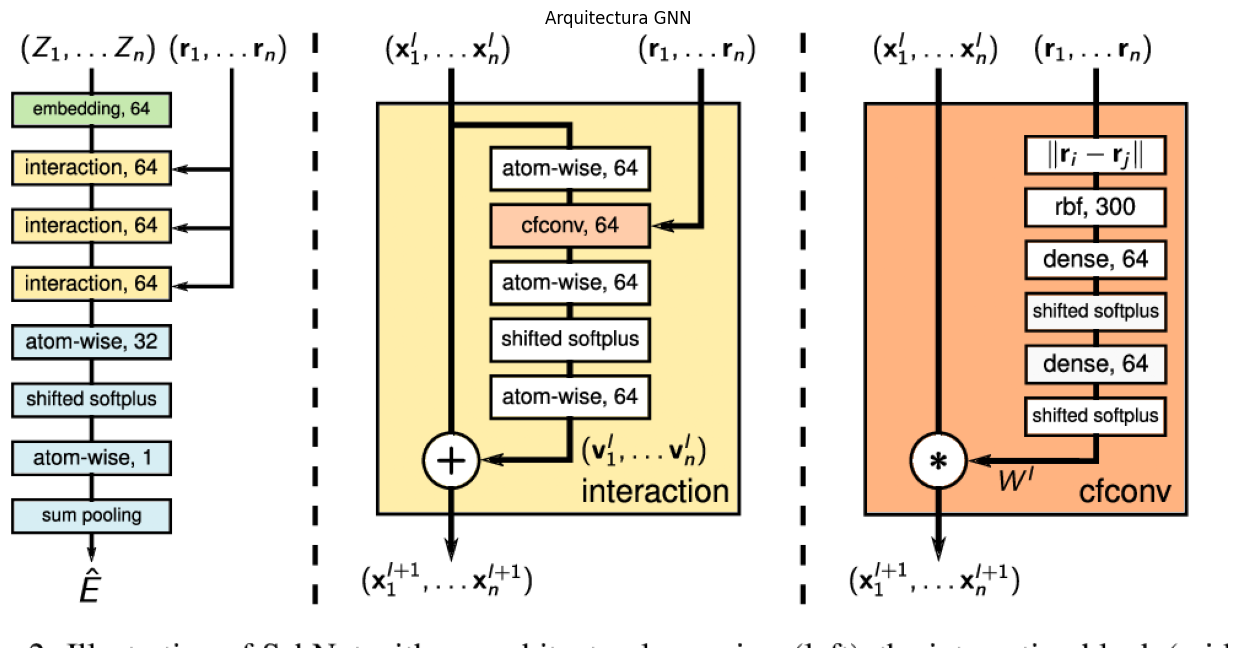

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Cargar la imagen
img = mpimg.imread('schnet_arq.png')

# Mostrar la imagen
plt.figure(figsize=(24, 8))
plt.imshow(img)
plt.axis('off')  # Oculta los ejes
plt.title('Arquitectura GNN')
plt.show()

Considerando un grafo dado por el siguiente esquema ([Peter W. Battaglia et al., 2019](https://arxiv.org/pdf/1806.01261))




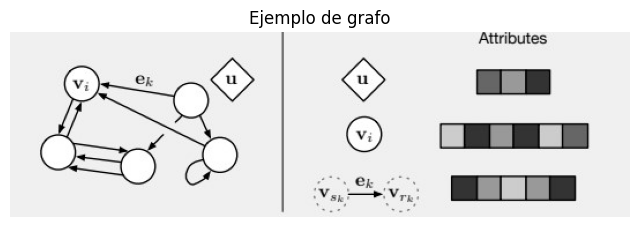

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Cargar la imagen
img = mpimg.imread('graph_example.jpg')

# Mostrar la imagen
plt.figure(figsize=(8, 5))
plt.imshow(img)
plt.axis('off')  # Oculta los ejes
plt.title('Ejemplo de grafo')
plt.show()

Las operaciones dentro de una GNN se pueden esquematizar por medio de las ecuaciones de Battaglia ([Peter W. Battaglia et al., 2019](https://arxiv.org/pdf/1806.01261)), las cuales identifican 3 operaciones principales de actualizacion de valores dentro de la red (`update`)

\begin{aligned}
e'_k &= \phi^e \left(e_k, \mathbf{v}_{r_k}, \mathbf{v}_{s_k}, \mathbf{u}\right) \\
\mathbf{v}'_i &= \phi^v \left(\mathbf{e}'_i, \mathbf{v}_i, \mathbf{u}\right) \\
\mathbf{u}' &= \phi^u \left(\mathbf{e}', \mathbf{v}', \mathbf{u}\right)
\end{aligned}
La primera operacion va relacionado a las **conexiones** entre nodos, donde influye su valor anterior $e_k$, los valores de los nodos vecinos y la propiedad global

La segunda operacion va relacionado a los **nodos**, donde depende del valor del nodo, de los enlaces que tiene y la propiedad global del grafo

La tercera operacion es sobre la **propiedad global**, y depende de los nodos y conexiones de todo el grafo.

Ademas de operaciones de actualizacion, existen las operaciones de agregacion `aggregation`, donde el superindice indica hacia que ...
\begin{aligned}
\mathbf{e}'_i &= \rho^{e \rightarrow v} \left(E'_i\right) \\
\mathbf{e}' &= \rho^{e \rightarrow u} \left(E'\right) \\
\mathbf{v}' &= \rho^{v \rightarrow u} \left(V'\right)
\end{aligned}

Donde se considera los siguientes subconjuntos $ E'_i = \{(e_k, r_k, s_k)\}_{r_k=i, k=1:N_e} $, $ V' = \{\mathbf{v}'_i\}_{i=1:N_v} $, and $E' = \bigcup_i E'_i = \{(e'_k, r_k, s_k)\}_{k=1:N_e} $.


Una operacion en SchNet
$$
 \mathbf{x}^{\prime}_i = \sum_{j \in \mathcal{N}(i)} \mathbf{x}_j \odot
        h_{\mathbf{\Theta}} ( \exp(-\gamma(\mathbf{e}_{j,i} - \mathbf{\mu})))
$$
Actualizacion
$$
  \mathbf{x}_i^{l+1} = \mathbf{x}_i^{l} + \mathbf{x}_i^{\prime}
$$

In [ ]:
!pip install schnetpack

Importar las librerias requeridas

In [1]:
import os
import schnetpack as spk
from schnetpack.datasets import QM9
import schnetpack.transform as trn
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import pandas as pd
import networkx as nx
import torch
import torchmetrics
import pytorch_lightning as pl


Descargar dataset qm9

In [2]:
#Se descargar sobre el archivo qm9.db, luego se carga este archivo en posteriores
#ejecuciones
%rm split.npz

qm9data = QM9(
    './qm9.db',
    batch_size=1,
    num_train=4000, #train+val set
    num_val=1,
    num_test=1000, # test set
    transforms=[
          trn.CastTo32()
     ],
    property_units={QM9.U0: 'kcal/mol',
                    QM9.G: 'kcal/mol'},
    num_workers=1,
    pin_memory=False, # set to false, when not using a GPU
    load_properties=[QM9.U0, QM9.G],
)
qm9data.prepare_data()
qm9data.setup()

rm: cannot remove 'split.npz': No such file or directory


100%|██████████| 133885/133885 [03:06<00:00, 718.21it/s]


## Visualizacion de energias G (Energia libre)

Se muestra la distribucion de energia U0 del dataset de entrenamiento + validacion previo a normalizar la data

,G (train+val) (kcal/mol)
count,4000.000000
mean,-209643.546875
std,30383.882812
min,-308771.093750
25%,-227030.242188
50%,-212287.976562
75%,-193583.265625
max,-25413.253906


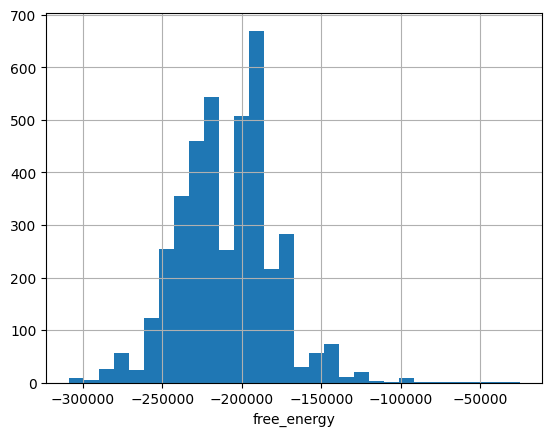

In [3]:
# Statistics
# U0_train = [dict_vals['energy_U0'].numpy()[0] for dict_vals in qm9data.train_dataset]
# U0_train = pd.Series(U0_train, name='U0 (train+val) (kcal/mol)')
# display(U0_train.describe())
# stats_U0_train = U0_train.describe()

# U0_test = [dict_vals['energy_U0'].numpy()[0] for dict_vals in qm9data.test_dataset]
# U0_test = pd.Series(U0_test, name='U0 (kcal/mol)')
# stats_U0_test = U0_test.describe()

# ax = U0_train.hist(bins=30)
# _ = ax.set_xlabel(QM9.U0)

G_train = [dict_vals['free_energy'].numpy()[0] for dict_vals in qm9data.train_dataset]
G_train = pd.Series(G_train, name='G (train+val) (kcal/mol)')
stats_G_train = G_train.describe()
display(G_train.describe())

G_test = [dict_vals['free_energy'].numpy()[0] for dict_vals in qm9data.test_dataset]
G_test = pd.Series(G_test, name='G (kcal/mol)')
stats_G_test = G_test.describe()

ax = G_train.hist(bins=30)
_ = ax.set_xlabel(QM9.G)

def norm_energy(val,stats):
  return (val-stats.mean())/stats.std()

def unnorm_energy(val,stats):
  return val*stats.std()+stats.mean()

Se importan los datos hacia Tensorflow

In [4]:
def generator():
  for dict_vals in qm9data.train_dataset:
      yield dict_vals['_positions'], dict_vals['_atomic_numbers'], norm_energy(dict_vals['free_energy'].numpy(), stats_G_train)

def generator_test():
  for dict_vals in qm9data.test_dataset:
    yield dict_vals['_positions'], dict_vals['_atomic_numbers'], dict_vals['free_energy'].numpy()

data = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(1), dtype=tf.float32)
    ),
).shuffle(4000, reshuffle_each_iteration=False,  # do not change order each time (!) otherwise will contaminate
)

test_data = tf.data.Dataset.from_generator(
    generator_test,
    output_signature=(
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(1), dtype=tf.float32)
    ),
).shuffle(1000, reshuffle_each_iteration=False,  # do not change order each time (!) otherwise will contaminate
)

train_data = data.take(3000)
val_data = data.skip(3000).take(1000)

Un grafico de algunas moleculas que se busca encontrar su energia G

Mean: -208580.656 (kcal/mol) 
Std: 29932.334 (kcal/mol) 
Max: -48523.695 (kcal/mol) 
Min: -296295.812 (kcal/mol) 



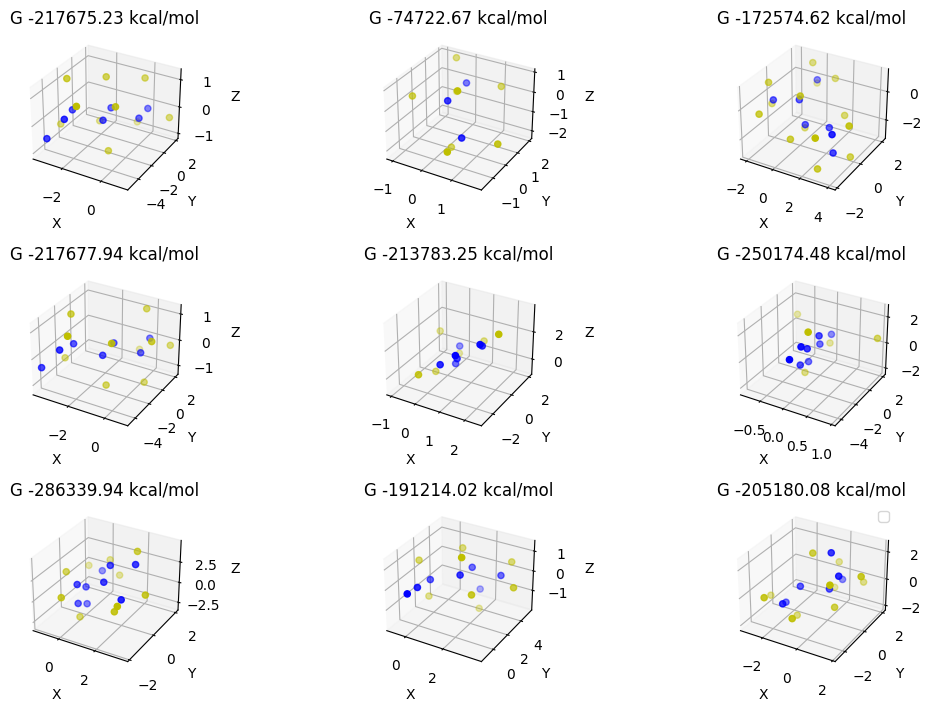

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8), subplot_kw={'projection': '3d'})
axs = axs.flatten()
dict_colors = {1:'y', 2: 'g', 3: 'y', 4: 'y', 5:'y', 6:'b' , 7:'b', 8:'b', 9:'b', 10:'b',
              11:'y', 12:'y', 13:'y', 14:'b', 15:'b', 16:'b', 17:'b', 18:'b', 19:'y', 20:'y'}
def color(val):
  return dict_colors[int(val)]
color_vec = np.vectorize(color)
print(f'Mean: {round(stats_G_test["mean"],3)} (kcal/mol) \nStd: {round(stats_G_test["std"],3)} (kcal/mol) \n\
Max: {round(stats_G_test["max"],3)} (kcal/mol) \nMin: {round(stats_G_test["min"],3)} (kcal/mol) \n')
# get a few examples and plot them
for i, (x, y, z) in enumerate(test_data):
    if i == 9:
        break
    # Graficar los puntos
    axs[i].scatter(x[:, 0], x[:, 1], x[:, 2], c=color_vec(y.numpy()), marker='o')
    num_title = np.around(z.numpy()[0],1)
    axs[i].set_title(f'G {round(float(z.numpy()[0]),2)} kcal/mol')
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    axs[i].set_zlabel('Z')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
plt.legend()
plt.show()


## Procesando los datos tipo grafo para la red

Para construir el filtro de convolucion "continuo", se requiere una funcion que calcule la distancia de dos nodos dados, `get_edges()` recibe las posiciones y la cantidad maxima de nodos vecinos que puede tener un nodo central. La estrategia es concentrar los $n$ vecinos mas cercanos de un nodo dado, esta funcion devuelve:

*   `-topk.values` : tensor shape $(\cdot ,N)$, que posee las $N$ distancias mas pequenas con respecto al atomo de la fila $i$
*   `topk.indices`: tensor shape $(\cdot ,N)$, que posee los $N$ indices correspondientes a los atomos mas cercanos al de la fila $i$


In [6]:
# this decorator speeds up the function by "compiling" it (tracing it)
# to run efficienty
@tf.function(
    reduce_retracing=True,
)
def get_edges(positions, NN, sorted=True):
    M = tf.shape(input=positions)[0] #number of points
    # adjust NN
    NN = tf.minimum(NN, M)
    qexpand = tf.expand_dims(positions, 1)  # add dim extra at 1
    qTexpand = tf.expand_dims(positions, 0)  # add dim extra at 0
    # repeat it to make matrix of all positions
    qtile = tf.tile(qexpand, [1, M, 1]) #repeat M times
    qTtile = tf.tile(qTexpand, [M, 1, 1])
    # subtract them to get distance matrix
    dist_mat = qTtile - qtile
    # mask distance matrix to remove zros (self-interactions)
    dist = tf.norm(tensor=dist_mat, axis=2)
    mask = dist >= 5e-4
    mask_cast = tf.cast(mask, dtype=dist.dtype) #matriz 0 y 1
    # make masked things be really far
    dist_mat_r = dist * mask_cast + (1 - mask_cast) * 1000
    topk = tf.math.top_k(-dist_mat_r, k=NN, sorted=sorted)
    return -topk.values, topk.indices

La informacion del dataset debe ser trabajada para ser usada dentro de la arquitectura, sobre esto ya se tiene la funcion `get_edges()` que calcula los nodos mas cercanos a un nodo dado. Esta informacion de distancia no se puede usar como filtro de forma directa, sino que se trabaja por medio de una rbf como la siguiente:
$$
e_k ( \mathbf{r}_i - \mathbf{r}_j ) = \exp\left(-\gamma \left(d_{ij} - \mu_k\right)^2\right)
$$

$$
 d_{ij} = \left\| \mathbf{r}_i - \mathbf{r}_j \right\|
$$

En especifico lo que se busca entregar a la red es:

- $\mathbf{x}_i^0$ (`y`): Vector que contiene los elementos atomicos que corresponden a los nodos de un grafo dado
- $e_k ( \mathbf{r}_i - \mathbf{r}_j )$ (`edge_features`) : Distancias de cada uno de los nodos del grafo, evaluadas sobre la funcion $e_k$
- `edge_i`: Tensor que dado un nodo $i$ tiene los $n$ nodos mas cercanos a este

In [7]:
MAX_DEGREE = 10 #cantidad de vecinos a un atomo dado
EDGE_FEATURES = 300 #cantidad de caracteristicas por distancia
MAX_R = 30 #hiperparametro de rbf

gamma = 10
mu = np.linspace(0, MAX_R, EDGE_FEATURES)


def rbf(r):
    return tf.exp(-gamma * (r[..., tf.newaxis] - mu) ** 2)


def make_graph(x, y, z):
    edge_r, edge_i = get_edges(x, MAX_DEGREE)
    edge_features = rbf(edge_r)
    return (y, edge_features, edge_i), z

graph_train_data = train_data.map(make_graph)
graph_val_data = val_data.map(make_graph)
graph_test_data = test_data.map(make_graph)


## Construir arquitectura SchNet by scratch (y en TensorFlow)

In [8]:
def ssp(x):
    # shifted softplus activation
    return tf.math.log(0.5 * tf.math.exp(x) + 0.5)


def make_h1(units):
    return tf.keras.Sequential([tf.keras.layers.Dense(units)])


def make_h2(units):
    return tf.keras.Sequential(
        [tf.keras.layers.Dense(units, activation=ssp),
         tf.keras.layers.Dense(units, activation=ssp)])

def make_h3(units):
    return tf.keras.Sequential(
        [tf.keras.layers.Dense(units, activation=ssp), tf.keras.layers.Dense(units)]
    )

class SchNetModel(tf.keras.Model):
    """Implementation of SchNet Model"""

    def __init__(self, gnn_blocks, channels, **kwargs):
        super(SchNetModel, self).__init__(**kwargs)
        self.gnn_blocks = gnn_blocks

        # build our layers
        self.embedding = tf.keras.layers.Embedding(20, channels) #transform to 1 to channels
        self.h1s = [make_h1(channels) for _ in range(self.gnn_blocks)]
        self.h2s = [make_h2(channels) for _ in range(self.gnn_blocks)]
        self.h3s = [make_h3(channels) for _ in range(self.gnn_blocks)]
        self.readout_l1 = tf.keras.layers.Dense(channels // 2, activation=ssp)
        self.readout_l2 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        nodes, edge_features, edge_i = inputs
        # turn node types as index to features
        nodes = self.embedding(nodes)
        for i in range(self.gnn_blocks):
            # get the node features per edge
            v_sk = tf.gather(nodes, edge_i) #choose closest atoms
            e_k = self.h1s[i](v_sk) * self.h2s[i](edge_features) #calculate directions of update atoms
            e_i = tf.reduce_sum(e_k, axis=1) #compute sum over all closest atoms
            nodes += self.h3s[i](e_i) #update node feature. The edge feature are not updated
        # readout now
        nodes = self.readout_l1(nodes)
        nodes = self.readout_l2(nodes)
        return tf.reduce_mean(nodes, axis=0) #invariant operation



In [9]:
small_schnet = SchNetModel(3, 64) #3 capas 30 canales

### Entrenamiento

Queda unicamente entrenar el modelo!, se elige la metrica mae (Mean Absolute Error) para comparar luego con SchNet

In [10]:
small_schnet.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-4), loss='mse', metrics=['mae']
)
# Train your model
result = small_schnet.fit(graph_train_data, validation_data=graph_val_data, epochs=50)

Epoch 1/50
   2999/Unknown 49s 11ms/step - loss: 0.0590 - mae: 0.1823

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 61s 15ms/step - loss: 0.0590 - mae: 0.1823 - val_loss: 0.0184 - val_mae: 0.1024
Epoch 2/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 90s 18ms/step - loss: 0.0186 - mae: 0.1071 - val_loss: 0.0139 - val_mae: 0.0889
Epoch 3/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - loss: 0.0128 - mae: 0.0886 - val_loss: 0.0103 - val_mae: 0.0770
Epoch 4/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - loss: 0.0088 - mae: 0.0726 - val_loss: 0.0089 - val_mae: 0.0721
Epoch 5/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step - loss: 0.0073 - mae: 0.0660 - val_loss: 0.0078 - val_mae: 0.0679
Epoch 6/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 75s 15ms/step - loss: 0.0065 - mae: 0.0621 - val_loss: 0.0070 - val_mae: 0.0646
Epoch 7/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 53s 15ms/step - loss: 0.0059 - mae: 0.0594 - val_loss: 0.0065 - val_mae: 0.0622
Epoch 8/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 69s 20ms/step - loss: 0.0056 - mae: 0.0575 - val_loss: 0.0062 - val_mae: 0.0604
Epoch 9/50
3000/3000 ━━━━━━━━━━━━━━

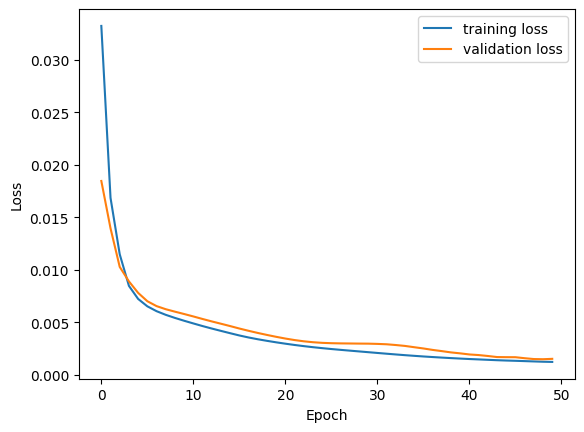

In [11]:
plt.plot(result.history["loss"], label="training loss")
plt.plot(result.history["val_loss"], label="validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Luego se evalua en base al test set, considerando quitar la normalizacion hecha sobre los datos

In [13]:
mae = 0
for i, (x, y) in enumerate(graph_test_data):
    yhat = unnorm_energy(small_schnet(x), stats_G_train)
    mae += abs(yhat[0] - y.numpy()[0])
print(f'MAE (Test set): {mae/(i+1)}')

MAE (Test set): 3571.75244140625


Como referencia MAE = 0.59 con 50k datos se reporta en el paper de Schnet(ref). Se grafica la estructura de los datos, la energia predicha y la prediccion hecha por la red

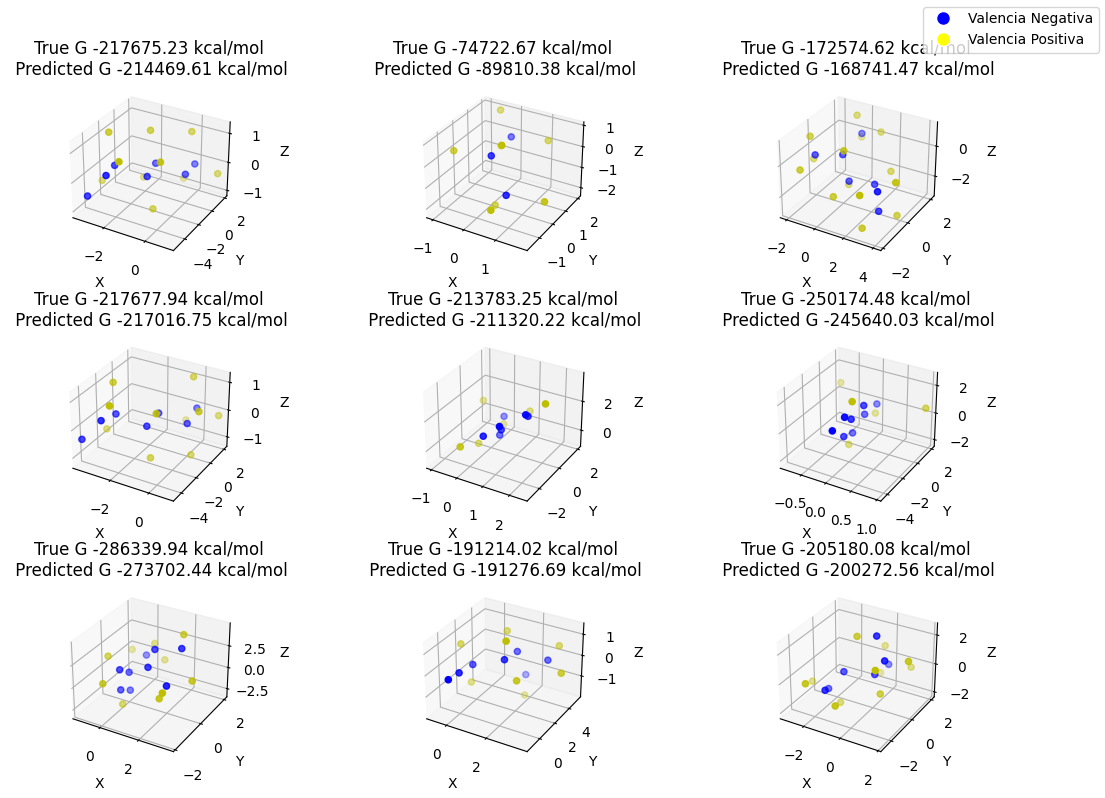

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8), subplot_kw={'projection': '3d'})
axs = axs.flatten()
dict_colors = {1:'y', 2: 'g', 3: 'y', 4: 'y', 5:'y', 6:'b' , 7:'b', 8:'b', 9:'b', 10:'g',
              11:'y', 12:'y', 13:'y', 14:'b', 15:'b', 16:'b', 17:'b', 18:'g', 19:'y', 20:'y'}
def color(val):
  return dict_colors[int(val)]
color_vec = np.vectorize(color)

for i, (x, y, z) in enumerate(test_data):
    if i == 9:
        break
    # Graficar los puntos
    axs[i].scatter(x[:, 0], x[:, 1], x[:, 2], c=color_vec(y.numpy()),marker='o')
    num_title = np.around(z.numpy()[0],1)
    (xi), eta = make_graph(x, y, z)
    gnn_energy = unnorm_energy(small_schnet(xi), stats_G_test)
    axs[i].set_title(f'True G {round(float(z.numpy()[0]),2)} kcal/mol\n Predicted G {round(float(gnn_energy[0]),2)} kcal/mol')
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    axs[i].set_zlabel('Z')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.05, wspace=0.4, hspace=0.4)
# Añadir leyenda personalizada
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Valencia Negativa', markerfacecolor='blue', markersize=10)
yellow_patch = plt.Line2D([0], [0], marker='o', color='w', label='Valencia Positiva', markerfacecolor='yellow', markersize=10)
fig.legend(handles=[blue_patch, yellow_patch], loc='upper right')

plt.show()